In [1]:
import pandas as pd

# Cargar archivo
df = pd.read_csv(r"C:\Users\nono_\AppRegresion\data\autos_limpios.csv")


# Ver columnas únicas si querés explorar
print(df.columns)

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar solo las advertencias de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning)


Index(['marca', 'modelo', 'ano', 'color', 'tipo de combustible', 'puertas',
       'transmision', 'motor', 'tipo de carroceria', 'fecha publicacion',
       'kilometros', 'precio', 'traccion'],
      dtype='object')


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Variables numéricas
variables_numericas = ['ano', 'kilometros', 'motor']

# Variables categóricas originales (antes de hacer dummies)
vars_categoricas_originales = ['marca', 'modelo', 'color', 'tipo de combustible',
                              'puertas', 'transmision', 'tipo de carroceria', 'traccion']

# Variables categóricas que queremos usar (para seleccionar dummies luego)
vars_categoricas_seleccionadas = ['marca', 'modelo' ,'transmision', 'traccion']#'tipo de carroceria','tipo de combustible'

# --- 1. Convertir todas las variables categóricas originales a dummies de una ---
df_dummies = pd.get_dummies(df, columns=vars_categoricas_originales, drop_first=False)  
# (drop_first=False para conservar todas las categorías; podés ajustar si querés evitar multicolinealidad)

# --- 2. Obtener las columnas dummy seleccionadas (de las variables categóricas seleccionadas) ---
dummies_seleccionadas = []
for var_cat in vars_categoricas_seleccionadas:
    prefijo = var_cat + "_"
    dummies_var = [col for col in df_dummies.columns if col.startswith(prefijo)]
    dummies_seleccionadas.extend(dummies_var)

# --- 3. Lista final de variables para el modelo: numéricas + dummies seleccionadas ---
variables_seleccionadas = variables_numericas + dummies_seleccionadas

# --- 4. Definir X e y ---
X = df_dummies[variables_seleccionadas]
y = df_dummies['precio']  # o df['precio'], ambos funcionan igual aquí

import pickle
columnas_modelo = X.columns.tolist()
with open(r'C:\Users\nono_\AppRegresion\data\columnas_modelo.pkl', 'wb') as f:
    pickle.dump(columnas_modelo, f)

# --- 5. Separar en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 6. Escalar variables numéricas ---
scaler = StandardScaler()
num_vars = [var for var in variables_numericas if var in X.columns]

X_train = X_train.copy()
X_test  = X_test.copy()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars]  = scaler.transform(X_test[num_vars])

# Guardamos el scaler para usarlo luego en la app
import pickle
with open(r'C:\Users\nono_\AppRegresion\data\scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# --- 7. Diccionario para guardar resultados ---
resultados = {}


# Número de folds para CV
cv_folds = 5

# --- 8. Modelos y evaluación con cross-validation ---

# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)
cv_scores_lr = cross_val_score(model_lr, X_train, y_train, cv=cv_folds, scoring='r2')

resultados['LinearRegression'] = {
    'train_r2': r2_score(y_train, y_pred_train),
    'test_r2': r2_score(y_test, y_pred_test),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'cv_r2_mean': cv_scores_lr.mean(),
    'cv_r2_std': cv_scores_lr.std()
}

print("Linear Regression:")
print("Train R2:", resultados['LinearRegression']['train_r2'])
print("Test R2:", resultados['LinearRegression']['test_r2'])
print("Test RMSE:", resultados['LinearRegression']['test_rmse'])
print(f"Cross-Validation R2: {resultados['LinearRegression']['cv_r2_mean']:.4f} ± {resultados['LinearRegression']['cv_r2_std']:.4f}")

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv_folds, scoring='r2')

resultados['RandomForest'] = {
    'train_r2': r2_score(y_train, y_train_pred_rf),
    'test_r2': r2_score(y_test, y_test_pred_rf),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'cv_r2_mean': cv_scores_rf.mean(),
    'cv_r2_std': cv_scores_rf.std()
}

print("\nRandom Forest:")
print("Train R2:", resultados['RandomForest']['train_r2'])
print("Test R2:", resultados['RandomForest']['test_r2'])
print("Test RMSE:", resultados['RandomForest']['test_rmse'])
print(f"Cross-Validation R2: {resultados['RandomForest']['cv_r2_mean']:.4f} ± {resultados['RandomForest']['cv_r2_std']:.4f}")


import xgboost as xgb

# Convertir datos a DMatrix para xgb.cv
dtrain = xgb.DMatrix(X, label=y)

# Parámetros básicos para xgb.cv
params = {
    'objective': 'reg:squarederror',
    'seed': 42,
    'verbosity': 0,
}

num_boost_round = 100
early_stopping_rounds = 10
nfold = cv_folds

# Ejecutar xgb.cv
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    nfold=nfold,
    metrics='rmse',
    early_stopping_rounds=early_stopping_rounds,
    seed=42,
    as_pandas=True,
    verbose_eval=False
)

print("\nXGBoost CV results (últimas filas):")
print(cv_results.tail())

# Mejor número de rounds según CV (min rmse)
best_num_boost_round = cv_results['test-rmse-mean'].idxmin()
print(f"Mejor número de rounds según CV: {best_num_boost_round}")

# Entrenar modelo final con el mejor número de rounds
xgb_model = XGBRegressor(
    n_estimators=best_num_boost_round,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predicciones
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Guardar resultados
resultados['XGBoost'] = {
    'train_r2': r2_score(y_train, y_train_pred_xgb),
    'test_r2': r2_score(y_test, y_test_pred_xgb),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)),
    'cv_r2_mean': None,  # No disponible con xgb.cv()
    'cv_r2_std': None
}

print("\nXGBoost (modelo final con CV interno):")
print("Train R2:", resultados['XGBoost']['train_r2'])
print("Test R2:", resultados['XGBoost']['test_r2'])
print("Test RMSE:", resultados['XGBoost']['test_rmse'])


Linear Regression:
Train R2: 0.8732890401715137
Test R2: 0.8707422642785403
Test RMSE: 4003389.231391993
Cross-Validation R2: 0.8725 ± 0.0060

Random Forest:
Train R2: 0.9883845953789149
Test R2: 0.9526178591574072
Test RMSE: 2423856.386843519
Cross-Validation R2: 0.9475 ± 0.0024

XGBoost CV results (últimas filas):
    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
95     2.022061e+06     9512.222595    2.304645e+06   16691.922332
96     2.020747e+06    10347.726607    2.304115e+06   16866.599437
97     2.019032e+06     9747.421796    2.304630e+06   15282.119730
98     2.016822e+06    10856.879500    2.303984e+06   14982.033178
99     2.014434e+06    11351.119417    2.303455e+06   15421.701767
Mejor número de rounds según CV: 99

XGBoost (modelo final con CV interno):
Train R2: 0.9656849503517151
Test R2: 0.9576589465141296
Test RMSE: 2291291.929328954


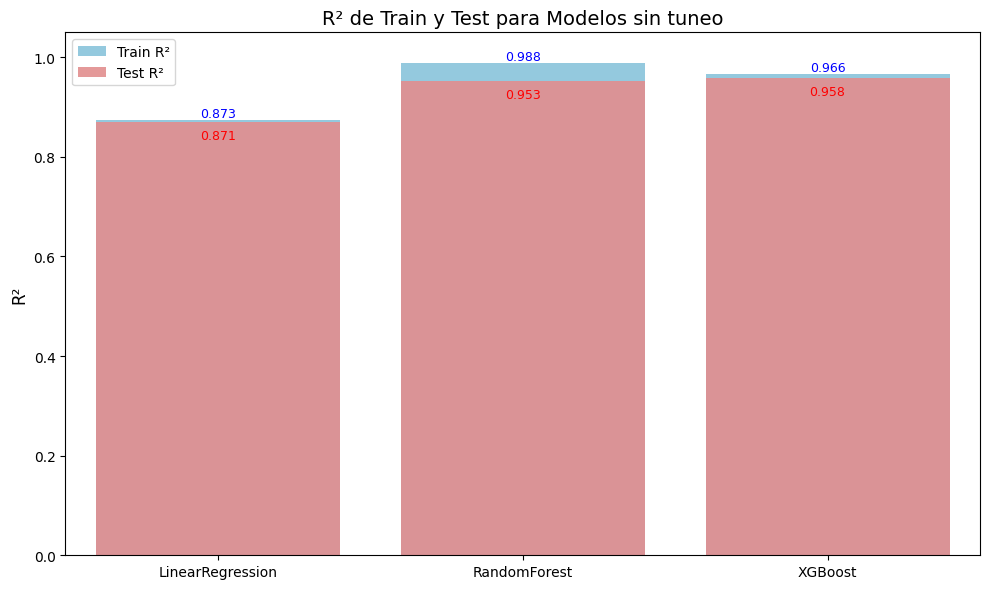

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir diccionario a DataFrame transpuesto
df_res = pd.DataFrame(resultados).T

# Asegurarse que el índice es columna para usarlo en el eje x
df_res = df_res.reset_index().rename(columns={'index':'Modelo'})

plt.figure(figsize=(10,6))
ax = sns.barplot(x='Modelo', y='train_r2', data=df_res, color='skyblue', label='Train R²', alpha=1)
sns.barplot(x='Modelo', y='test_r2', data=df_res, color='lightcoral', label='Test R²', alpha=0.9, ax=ax)


 # Añadir los valores encima de cada barra (train_r2) arriba de la barra
for i, val in enumerate(df_res['train_r2']):  
        ax.text(i, val + 0.00, f"{val:.3f}", ha='center', va='bottom', color='blue', fontsize=9)

# Añadir los valores encima de cada barra (test_r2), y para 'LinearRegression' un poco más abajo
for i, val in enumerate(df_res['test_r2']):
        ax.text(i, val - 0.04, f"{val:.3f}", ha='center', va='bottom', color='red', fontsize=9)


plt.title("R² de Train y Test para Modelos sin tuneo", fontsize=14)
plt.xlabel("", fontsize=12)
plt.ylabel("R²", fontsize=12)
plt.ylim(0, 1.05)
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("C:/Users/nono_/AppRegresion/data/r2_modelosconeleccion_sin_tuneo.png", dpi=300, bbox_inches='tight')
plt.show()






In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir rejilla de hiperparámetros
#{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 400}
param_grid_rf = {
    'n_estimators': [400,500],
    'max_depth': [30,40],
    'min_samples_split': [11,13],
    'min_samples_leaf': [1,2],
    'max_features': ['sqrt']
}

# Modelo base
rf = RandomForestRegressor(random_state=42)

# Búsqueda con CV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='r2',
    cv=cv_folds,
    n_jobs=-1,
    verbose=0
)

grid_search_rf.fit(X_train, y_train)

# Mejores parámetros
print("Mejores hiperparámetros (Random Forest):")
print(grid_search_rf.best_params_)

# R^2 en test con mejores hiperparámetros
best_rf = grid_search_rf.best_estimator_
print("Test R2:", r2_score(y_test, best_rf.predict(X_test)))

# Guardar resultados optimizados para Random Forest
resultados['RandomForest_tuneado'] = {
    'train_r2': r2_score(y_train, best_rf.predict(X_train)),
    'test_r2': r2_score(y_test, best_rf.predict(X_test)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test))),
    'cv_r2_mean': grid_search_rf.best_score_,
    'cv_r2_std': None  # No disponible directamente
}

# --- 8bis. XGBoost con monotonicidad en kilómetros ---

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV



# 2) Construimos la lista de restricciones de monotonicidad:
monotonic_list = [0] * X_train.shape[1]                # 0 = sin restricción
idx_km = list(X_train.columns).index('kilometros')     # posición de 'kilometros'
monotonic_list[idx_km] = -1                            # -1 = decreciente
monotone_constraints = tuple(monotonic_list)           # tupla para XGBoost

# 3) Espacio de búsqueda para hiperparámetros
param_dist_xgb = {
    'n_estimators':     [300],
    'max_depth':        [7, 8, 9],
    'learning_rate':    [0.03, 0.05],
    'subsample':        [0.9],
    'colsample_bytree': [0.9, 0.95],
    'gamma':            [0.25],
    'min_child_weight': [3],
    # aquí pasamos la tupla construida dinámicamente
    'monotone_constraints': [monotone_constraints]
}

# 4) Construimos el modelo y lanzamos la búsqueda
xgb = XGBRegressor(random_state=42, verbosity=0)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    scoring='r2',
    n_iter=30,
    cv=cv_folds,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

# 5) Recuperamos el mejor estimador y lo guardamos
best_xgb = random_search_xgb.best_estimator_

print("Mejores hiperparámetros (XGBoost con monotonicidad):")
print(random_search_xgb.best_params_)
print("Test R2:", r2_score(y_test, best_xgb.predict(X_test)))

# 6) Actualizamos resultados
resultados['XGBoost_tuneado'] = {
    'train_r2': r2_score(y_train, best_xgb.predict(X_train)),
    'test_r2':  r2_score(y_test,  best_xgb.predict(X_test)),
    'test_rmse': np.sqrt(mean_squared_error(y_test, best_xgb.predict(X_test))),
    'cv_r2_mean': random_search_xgb.best_score_,
    'cv_r2_std':  None
}

# 7) Guardamos el nuevo modelo para tu app Flask
import pickle
ruta_guardado = r'C:\Users\nono_\AppRegresion\data\mejor_modelo_xgb.pkl'
with open(ruta_guardado, 'wb') as file:
    pickle.dump(best_xgb, file)



Mejores hiperparámetros (Random Forest):
{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 500}
Test R2: 0.953624482795058


c:\Users\nono_\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros (XGBoost con monotonicidad):
{'subsample': 0.9, 'n_estimators': 300, 'monotone_constraints': (0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.25, 'colsample_bytree': 0.95}
Test R2: 0.9590513706207275


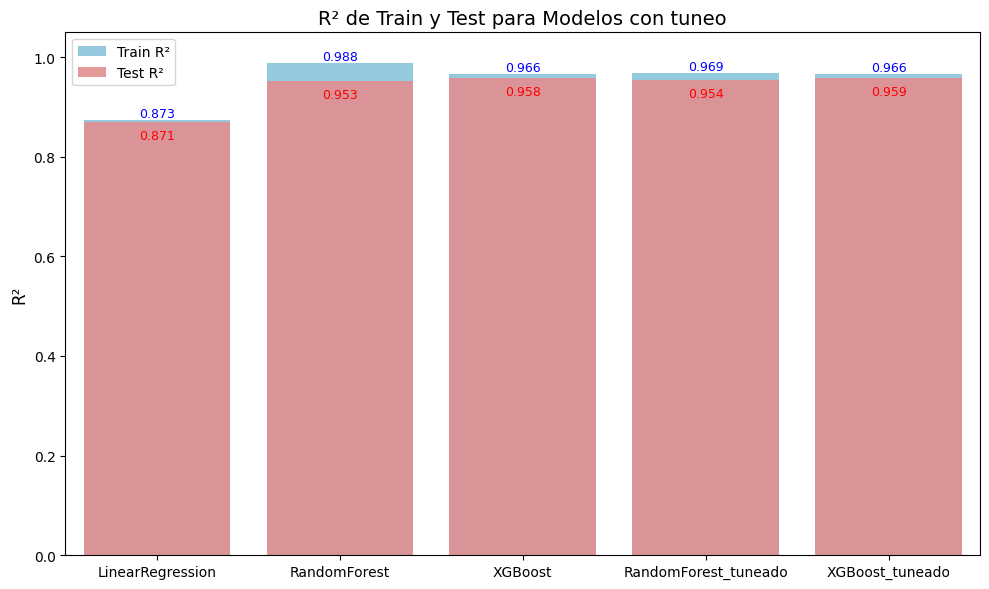

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir diccionario a DataFrame transpuesto
df_res = pd.DataFrame(resultados).T

# Asegurarse que el índice es columna para usarlo en el eje x
df_res = df_res.reset_index().rename(columns={'index':'Modelo'})

plt.figure(figsize=(10,6))
ax = sns.barplot(x='Modelo', y='train_r2', data=df_res, color='skyblue', label='Train R²', alpha=1)
sns.barplot(x='Modelo', y='test_r2', data=df_res, color='lightcoral', label='Test R²', alpha=0.9, ax=ax)


 # Añadir los valores encima de cada barra (train_r2) arriba de la barra
for i, val in enumerate(df_res['train_r2']):  
        ax.text(i, val + 0.00, f"{val:.3f}", ha='center', va='bottom', color='blue', fontsize=9)

# Añadir los valores encima de cada barra (test_r2), y para 'LinearRegression' un poco más abajo
for i, val in enumerate(df_res['test_r2']):
        ax.text(i, val - 0.04, f"{val:.3f}", ha='center', va='bottom', color='red', fontsize=9)


plt.title("R² de Train y Test para Modelos con tuneo", fontsize=14)
plt.xlabel("", fontsize=12)
plt.ylabel("R²", fontsize=12)
plt.ylim(0, 1.05)
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("C:/Users/nono_/AppRegresion/data/r2_modelosconeleccion_con_tuneo.png", dpi=300, bbox_inches='tight')
plt.show()

